# 2018 Yellow Taxi Trip Data Analysis

- Read taxi-sample and shape files
- Data cleaning (removing null values, trip duration 0 etc.)

In [1]:
import pandas as pd
import numpy as np
import shapefile
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

In [2]:
taxiSample = pd.read_csv("data/taxi-sample.csv")
print(taxiSample.head())

   VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0         2  11/04/2084 12:32:24 PM  11/04/2084 12:47:41 PM                1   
1         2  11/04/2084 12:32:24 PM  11/04/2084 12:47:41 PM                1   
2         2  11/04/2084 12:25:53 PM  11/04/2084 12:29:00 PM                1   
3         2  11/04/2084 12:25:53 PM  11/04/2084 12:29:00 PM                1   
4         2  11/04/2084 12:08:33 PM  11/04/2084 12:22:24 PM                1   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.34           1                  N           238           236   
1           1.34           1                  N           238           236   
2           0.32           1                  N           238           238   
3           0.32           1                  N           238           238   
4           1.85           1                  N           236           238   

   payment_type  fare_amount  extra  mta_tax

In [3]:
print(taxiSample.shape)

(1048576, 17)


In [4]:
taxiSample.isnull().any()

VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count          False
trip_distance            False
RatecodeID               False
store_and_fwd_flag       False
PULocationID             False
DOLocationID             False
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
dtype: bool

In [5]:
trip_dist = taxiSample[taxiSample.trip_distance <= 0]
print(trip_dist.shape)

(8463, 17)


In [6]:
pass_count = taxiSample[taxiSample.passenger_count <= 0]
print(pass_count.shape)

(15296, 17)


In [7]:
taxiSample = taxiSample[taxiSample.trip_distance > 0]
print(taxiSample.shape)

(1040113, 17)


In [8]:
taxiSample = taxiSample[taxiSample.passenger_count > 0]
print(taxiSample.shape)

(1025074, 17)


In [9]:
taxiZones = shapefile.Reader("data/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in taxiZones.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
print(shp_dic)

attributes = taxiZones.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]
print(shp_attr[:5])

{'OBJECTID': 0, 'Shape_Leng': 1, 'Shape_Area': 2, 'zone': 3, 'LocationID': 4, 'borough': 5}
[{'OBJECTID': 1, 'Shape_Leng': 0.116357453189, 'Shape_Area': 0.0007823067885, 'zone': 'Newark Airport', 'LocationID': 1, 'borough': 'EWR'}, {'OBJECTID': 2, 'Shape_Leng': 0.43346966679, 'Shape_Area': 0.00486634037837, 'zone': 'Jamaica Bay', 'LocationID': 2, 'borough': 'Queens'}, {'OBJECTID': 3, 'Shape_Leng': 0.0843411059012, 'Shape_Area': 0.000314414156821, 'zone': 'Allerton/Pelham Gardens', 'LocationID': 3, 'borough': 'Bronx'}, {'OBJECTID': 4, 'Shape_Leng': 0.0435665270921, 'Shape_Area': 0.000111871946192, 'zone': 'Alphabet City', 'LocationID': 4, 'borough': 'Manhattan'}, {'OBJECTID': 5, 'Shape_Leng': 0.0921464898574, 'Shape_Area': 0.000497957489363, 'zone': 'Arden Heights', 'LocationID': 5, 'borough': 'Staten Island'}]


In [10]:
def get_lat_lon(taxiZones):
    content = []
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [11]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(taxiZones).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


In [12]:
boroughs = df_loc['borough'].unique()
print(boroughs)

['EWR' 'Queens' 'Bronx' 'Manhattan' 'Staten Island' 'Brooklyn']


In [13]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [14]:
def draw_region_map(ax, taxiZones, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'EWR':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'Staten Island':5, 'Brooklyn':6}
    reg_x = {'EWR':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Staten Island':[], 'Brooklyn':[]}
    reg_y = {'EWR':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Staten Island':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(taxiZones)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [15]:
def draw_zone_map(ax, taxiZones, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(taxiZones)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

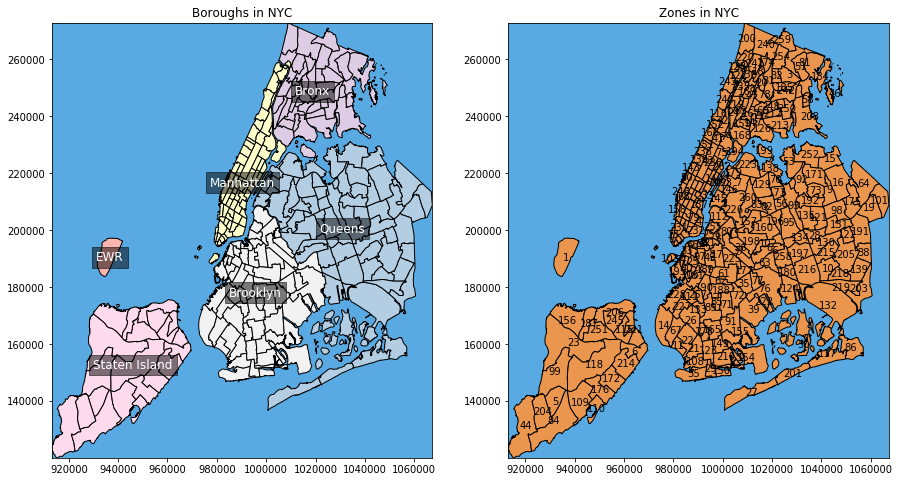

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, taxiZones)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, taxiZones)